# File Info

Training for functions for neural odes. v1 contains training data segmented into pairs. This training failed. 

In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v1 as nodes
import models.DynamicalSystems as ds

# Data Generation



In [2]:
lc = ds.Hopf(rho=1.0, alpha=-1.0, beta=0.0)

In [3]:
a = torch.arange(-2.0, 2.0, 1.0); c = torch.ones_like(a)

r_vals = torch.arange(1, 5.0, 1.0)
ic = torch.cartesian_prod(a, a, r_vals)  #traj, dim




In [4]:
lc.gamma = 0.1
lc.f = lc.na_f

In [5]:
t_span = (0, 10); dt = 0.05
ic.shape #traj, dim

sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )

In [6]:
time = torch.arange(t_span[0], t_span[1], dt).unsqueeze(1).unsqueeze(2)  #(time, 1, 1)
time.shape

torch.Size([200, 1, 1])

In [7]:
#time_expanded = time.repeat(1, ic.shape[0], 1)  #(time, traj, 1)
#time_expanded.shape

In [8]:
#sol2 = torch.cat((sol, time_expanded), dim=-1)  #(time, traj, dim+1)
#sol.shape

In [8]:
data_tensor = torch.stack((sol[0:-4, :, :], sol[1:-3, :, :]), dim=1)

In [9]:
list = []
for i in range(data_tensor.shape[2]):
    list.append(data_tensor[:,:,i,:])

In [10]:
data_tensor = torch.concat(list, dim=0)

In [11]:

data_loader = torch.utils.data.DataLoader(data_tensor, batch_size=64, shuffle=True)

In [12]:
data_loader.dataset.shape

torch.Size([12544, 2, 3])

# Model 

In [34]:
class Trainer:
    def __init__(self, model, data_loader, optimizer, loss_fn, t_eval):
        self.model = model
        self.data_loader = data_loader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.t_eval = t_eval
        self.loss_list = []
        self.epoch_trained = 0

        pred_x = odeint(func=self.model, y0=data_loader.dataset[:, 0, :], t=self.t_eval, method='rk4', options={'step_size': dt})
        loss = self.loss_fn(pred_x[-1, :, :], data_loader.dataset[:, 1, :])
        self.loss_list.append(loss.item())

    def train(self, num_epochs, t_eval, dt):
        
        for epoch in tqdm(range(num_epochs), desc= "Current Loss: " + str(self.loss_list[-1]) + "  - Epochs: " + str(self.epoch_trained)):
            self.epoch_trained += 1
            epoch_loss = 0.0
            for i, (x_batch) in enumerate(self.data_loader): #x_batch shape (num_traj, 2, dim)

                self.optimizer.zero_grad()
                
                #ODE integration to get predictions + compute loss
                pred_x = odeint(func=self.model, y0=x_batch[:, 0, :], t=self.t_eval, method='rk4', options={'step_size': dt})
                loss = self.loss_fn(pred_x[-1, :, :], x_batch[:, 1, :])
                epoch_loss += loss.item()
                
                #Backpropagation and optimization step
                loss.backward()
                self.optimizer.step()

            avg_epoch_loss = epoch_loss / len(self.data_loader)
            self.loss_list.append(avg_epoch_loss)
    

In [35]:
model = nodes.NODE2(input_dim=3, output_dim=3, hidden_dim=32, depth=4, activation_func=nn.Tanh())

In [36]:
t_eval = torch.arange(0, 0.1, dt)
t_eval

tensor([0.0000, 0.0500])

In [37]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()



In [38]:
trainer = Trainer(model=model, data_loader=data_loader, optimizer=optimizer, loss_fn=loss_fn, t_eval=t_eval)

In [ ]:
trainer.train(num_epochs=100, t_eval=t_eval, dt=dt)

Current Loss: 0.0027796784415841103  - Epochs: 0:  51%|█████     | 51/100 [00:40<00:41,  1.17it/s]

In [25]:
data_loader.dataset.shape

torch.Size([12544, 2, 3])

In [26]:
t_eval = torch.arange(0, 0.1, dt)
t_eval

tensor([0.0000, 0.0500])

In [27]:
pred_x = odeint(func=model, y0=data_loader.dataset[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
loss = loss_fn(pred_x[-1, :, :, ], data_loader.dataset[:,1,:]) 
loss

tensor(0.0031, grad_fn=<MseLossBackward0>)

In [28]:
print(pred_x[-1, :, :].shape)
print(data_loader.dataset[:,1,:].shape)

torch.Size([12544, 3])
torch.Size([12544, 3])


In [ ]:
def train(model, data_loader, optimizer, loss_fn, t_eval, num_epochs=100):
    #index = ((dt/model.dt)*torch.arange(1, data_loader.dataset.shape[1], 1)).int() -1 #number of NODE steps to reach data time span
    for epoch in tqdm(range(num_epochs)):
        for i, (x_batch) in enumerate(data_loader): #(num_pairs, pairs, traj, dim)
            
            optimizer.zero_grad()

            # Predicting the trajectory
            pred_x = odeint(func=model, y0=x_batch[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
            loss = loss_fn(pred_x[-1, :, :, ], x_batch[:,1,:]) 
            loss
                    

            # Backpropagation
            loss.backward()
            optimizer.step()

In [29]:
# Longer as 20 backpropagations
num_epochs = 2000
#index = ((dt/model.dt)*torch.arange(1, data_loader.dataset.shape[1], 1)).int() -1 #number of NODE steps to reach data time span
for epoch in tqdm(range(num_epochs)):
    for i, (x_batch) in enumerate(data_loader): #(num_pairs, pairs, traj, dim)
        
        optimizer.zero_grad()

        # Predicting the trajectory
        pred_x = odeint(func=model, y0=x_batch[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
        loss = loss_fn(pred_x[-1, :, :, ], x_batch[:,1,:]) 
        loss
                

        # Backpropagation
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        pred_x = odeint(func=model, y0=data_loader.dataset[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
        loss = loss_fn(pred_x[-1, :, :, ], data_loader.dataset[:,1,:]) 
        loss_list.append(loss.item())

  0%|          | 1/2000 [00:00<27:18,  1.22it/s]

Epoch 0, Loss: 7.207503949757665e-05


  1%|          | 21/2000 [00:16<25:33,  1.29it/s]

Epoch 20, Loss: 5.48030948266387e-06


  2%|▏         | 41/2000 [00:36<42:11,  1.29s/it]

Epoch 40, Loss: 6.12529220234137e-06


  3%|▎         | 61/2000 [01:10<53:59,  1.67s/it]

Epoch 60, Loss: 1.8163719914809917e-06


  4%|▍         | 81/2000 [01:42<51:31,  1.61s/it]

Epoch 80, Loss: 8.630415209154307e-07


  5%|▌         | 101/2000 [02:15<49:52,  1.58s/it]

Epoch 100, Loss: 1.1620765008046874e-06


  6%|▌         | 121/2000 [02:46<48:36,  1.55s/it]

Epoch 120, Loss: 9.390259378960764e-07


  7%|▋         | 141/2000 [03:17<47:46,  1.54s/it]

Epoch 140, Loss: 4.846359047405713e-07


  8%|▊         | 161/2000 [03:49<48:29,  1.58s/it]

Epoch 160, Loss: 1.4398193570741569e-06


  9%|▉         | 181/2000 [04:21<48:09,  1.59s/it]

Epoch 180, Loss: 3.1332174899034726e-07


 10%|█         | 201/2000 [04:54<47:13,  1.57s/it]

Epoch 200, Loss: 3.0791392191531486e-07


 11%|█         | 221/2000 [05:25<46:30,  1.57s/it]

Epoch 220, Loss: 2.00076669898408e-06


 12%|█▏        | 241/2000 [05:57<46:28,  1.59s/it]

Epoch 240, Loss: 4.858725333178882e-07


 13%|█▎        | 261/2000 [06:31<49:36,  1.71s/it]

Epoch 260, Loss: 7.156615993153537e-07


 14%|█▍        | 281/2000 [07:04<46:42,  1.63s/it]

Epoch 280, Loss: 2.94425632318962e-07


 15%|█▌        | 301/2000 [07:37<48:36,  1.72s/it]

Epoch 300, Loss: 3.3383594200131483e-07


 16%|█▌        | 321/2000 [08:12<50:37,  1.81s/it]

Epoch 320, Loss: 6.993082735107237e-08


 17%|█▋        | 341/2000 [08:46<46:48,  1.69s/it]

Epoch 340, Loss: 1.5580141621285293e-07


 18%|█▊        | 361/2000 [09:19<45:27,  1.66s/it]

Epoch 360, Loss: 2.582075637747039e-07


 19%|█▉        | 381/2000 [09:53<44:16,  1.64s/it]

Epoch 380, Loss: 2.2998439419552597e-07


 20%|██        | 401/2000 [10:25<45:16,  1.70s/it]

Epoch 400, Loss: 4.159601019182446e-07


 21%|██        | 421/2000 [11:00<45:36,  1.73s/it]

Epoch 420, Loss: 1.5120913587907125e-07


 22%|██▏       | 441/2000 [11:35<45:42,  1.76s/it]

Epoch 440, Loss: 2.7874332886312914e-07


 23%|██▎       | 461/2000 [12:09<43:15,  1.69s/it]

Epoch 460, Loss: 5.340241315821004e-08


 24%|██▍       | 481/2000 [12:43<42:48,  1.69s/it]

Epoch 480, Loss: 1.3593010805834638e-07


 25%|██▌       | 501/2000 [13:17<43:04,  1.72s/it]

Epoch 500, Loss: 1.765232156003549e-07


 26%|██▌       | 521/2000 [13:50<40:28,  1.64s/it]

Epoch 520, Loss: 8.172026610964167e-08


 27%|██▋       | 541/2000 [14:23<40:19,  1.66s/it]

Epoch 540, Loss: 5.906899218643957e-07


 28%|██▊       | 561/2000 [14:56<39:09,  1.63s/it]

Epoch 560, Loss: 5.448993647405587e-07


 29%|██▉       | 581/2000 [15:29<38:05,  1.61s/it]

Epoch 580, Loss: 6.311601055131177e-07


 30%|███       | 601/2000 [16:01<37:19,  1.60s/it]

Epoch 600, Loss: 1.8945671342862624e-07


 31%|███       | 621/2000 [16:34<37:46,  1.64s/it]

Epoch 620, Loss: 1.2637919155622512e-07


 32%|███▏      | 641/2000 [17:07<37:20,  1.65s/it]

Epoch 640, Loss: 1.686727500782581e-06


 33%|███▎      | 661/2000 [17:39<36:29,  1.63s/it]

Epoch 660, Loss: 2.9272050028339436e-07


 34%|███▍      | 681/2000 [18:12<35:34,  1.62s/it]

Epoch 680, Loss: 1.6082681497664453e-07


 35%|███▌      | 701/2000 [18:46<36:37,  1.69s/it]

Epoch 700, Loss: 3.5863942571268126e-07


 36%|███▌      | 721/2000 [19:19<36:06,  1.69s/it]

Epoch 720, Loss: 4.236861528283953e-08


 37%|███▋      | 741/2000 [19:53<34:42,  1.65s/it]

Epoch 740, Loss: 7.285188416972233e-07


 38%|███▊      | 761/2000 [20:26<34:06,  1.65s/it]

Epoch 760, Loss: 1.4903879730354674e-07


 39%|███▉      | 781/2000 [21:00<33:32,  1.65s/it]

Epoch 780, Loss: 4.3674706518004314e-08


 40%|████      | 801/2000 [21:33<33:44,  1.69s/it]

Epoch 800, Loss: 1.95645625922225e-07


 41%|████      | 821/2000 [22:07<33:33,  1.71s/it]

Epoch 820, Loss: 2.7752369646805164e-07


 42%|████▏     | 841/2000 [22:42<33:55,  1.76s/it]

Epoch 840, Loss: 7.163571780210987e-08


 43%|████▎     | 861/2000 [23:19<33:42,  1.78s/it]

Epoch 860, Loss: 5.0226208969661457e-08


 44%|████▍     | 881/2000 [23:54<33:13,  1.78s/it]

Epoch 880, Loss: 1.2488047218539577e-07


 45%|████▌     | 901/2000 [24:37<43:00,  2.35s/it]

Epoch 900, Loss: 1.4409651782898436e-07


 46%|████▌     | 921/2000 [25:17<31:38,  1.76s/it]

Epoch 920, Loss: 9.464347527909922e-08


 47%|████▋     | 941/2000 [25:53<32:37,  1.85s/it]

Epoch 940, Loss: 1.9963714237292152e-07


 48%|████▊     | 961/2000 [26:30<29:44,  1.72s/it]

Epoch 960, Loss: 5.845062034381954e-08


 49%|████▉     | 981/2000 [27:06<30:12,  1.78s/it]

Epoch 980, Loss: 1.3523974473628186e-07


 50%|█████     | 1001/2000 [27:42<33:32,  2.01s/it]

Epoch 1000, Loss: 9.300748047280649e-07


 51%|█████     | 1021/2000 [28:19<28:38,  1.76s/it]

Epoch 1020, Loss: 6.503965721549321e-08


 52%|█████▏    | 1041/2000 [28:54<27:31,  1.72s/it]

Epoch 1040, Loss: 2.4124423703142384e-07


 53%|█████▎    | 1061/2000 [29:27<26:01,  1.66s/it]

Epoch 1060, Loss: 1.8338892004976515e-07


 54%|█████▍    | 1081/2000 [30:01<24:58,  1.63s/it]

Epoch 1080, Loss: 1.0431869412741435e-07


 55%|█████▌    | 1101/2000 [30:35<24:50,  1.66s/it]

Epoch 1100, Loss: 2.0279527745969972e-07


 56%|█████▌    | 1121/2000 [31:08<24:18,  1.66s/it]

Epoch 1120, Loss: 4.297710347600514e-07


 57%|█████▋    | 1141/2000 [31:41<24:13,  1.69s/it]

Epoch 1140, Loss: 3.85133688496353e-07


 58%|█████▊    | 1161/2000 [32:16<24:51,  1.78s/it]

Epoch 1160, Loss: 1.6106586997466366e-07


 59%|█████▉    | 1181/2000 [32:50<23:43,  1.74s/it]

Epoch 1180, Loss: 1.5899030358923483e-07


 60%|██████    | 1201/2000 [33:24<21:53,  1.64s/it]

Epoch 1200, Loss: 2.00603793132359e-07


 61%|██████    | 1221/2000 [33:56<21:30,  1.66s/it]

Epoch 1220, Loss: 1.441344039676551e-07


 62%|██████▏   | 1241/2000 [34:29<20:24,  1.61s/it]

Epoch 1240, Loss: 6.937640932846989e-07


 63%|██████▎   | 1261/2000 [35:03<21:07,  1.71s/it]

Epoch 1260, Loss: 1.1213816009103539e-07


 64%|██████▍   | 1281/2000 [35:37<19:55,  1.66s/it]

Epoch 1280, Loss: 6.622570225545132e-08


 65%|██████▌   | 1301/2000 [36:10<19:20,  1.66s/it]

Epoch 1300, Loss: 2.2260076093516545e-07


 66%|██████▌   | 1321/2000 [36:43<18:28,  1.63s/it]

Epoch 1320, Loss: 5.393226274463814e-07


 67%|██████▋   | 1341/2000 [37:15<18:18,  1.67s/it]

Epoch 1340, Loss: 1.201436816700152e-07


 68%|██████▊   | 1361/2000 [37:49<18:33,  1.74s/it]

Epoch 1360, Loss: 2.2267153099164716e-07


 69%|██████▉   | 1381/2000 [38:25<18:35,  1.80s/it]

Epoch 1380, Loss: 1.975560763867179e-07


 70%|███████   | 1401/2000 [38:59<16:57,  1.70s/it]

Epoch 1400, Loss: 4.7737419350823984e-08


 71%|███████   | 1421/2000 [39:33<16:53,  1.75s/it]

Epoch 1420, Loss: 3.407933490962023e-07


 72%|███████▏  | 1441/2000 [40:08<16:02,  1.72s/it]

Epoch 1440, Loss: 1.1286581980129995e-07


 73%|███████▎  | 1461/2000 [40:43<15:54,  1.77s/it]

Epoch 1460, Loss: 3.1973755199032894e-07


 74%|███████▍  | 1481/2000 [41:18<14:37,  1.69s/it]

Epoch 1480, Loss: 5.847620698773426e-08


 75%|███████▌  | 1501/2000 [41:52<14:02,  1.69s/it]

Epoch 1500, Loss: 1.0365675251478024e-07


 76%|███████▌  | 1521/2000 [42:26<13:27,  1.69s/it]

Epoch 1520, Loss: 8.488294156450138e-08


 77%|███████▋  | 1541/2000 [43:00<13:01,  1.70s/it]

Epoch 1540, Loss: 1.1460208071412126e-07


 78%|███████▊  | 1561/2000 [43:34<12:22,  1.69s/it]

Epoch 1560, Loss: 3.0847144216750166e-07


 79%|███████▉  | 1581/2000 [44:07<11:33,  1.65s/it]

Epoch 1580, Loss: 4.75099710683935e-08


 80%|████████  | 1601/2000 [44:41<11:52,  1.79s/it]

Epoch 1600, Loss: 2.228552489214053e-07


 81%|████████  | 1621/2000 [45:16<10:42,  1.69s/it]

Epoch 1620, Loss: 2.3464876619527786e-07


 82%|████████▏ | 1641/2000 [45:50<10:06,  1.69s/it]

Epoch 1640, Loss: 3.3600153415136447e-07


 83%|████████▎ | 1661/2000 [46:24<09:46,  1.73s/it]

Epoch 1660, Loss: 1.0348406931370846e-07


 84%|████████▍ | 1681/2000 [46:57<08:53,  1.67s/it]

Epoch 1680, Loss: 1.2026345075355493e-07


 85%|████████▌ | 1701/2000 [47:31<08:30,  1.71s/it]

Epoch 1700, Loss: 2.3482927247187035e-07


 86%|████████▌ | 1721/2000 [48:05<08:08,  1.75s/it]

Epoch 1720, Loss: 9.562261737983135e-08


 87%|████████▋ | 1741/2000 [48:39<07:17,  1.69s/it]

Epoch 1740, Loss: 2.038634647760773e-07


 88%|████████▊ | 1761/2000 [49:13<06:43,  1.69s/it]

Epoch 1760, Loss: 4.910295388071972e-07


 89%|████████▉ | 1781/2000 [49:47<06:40,  1.83s/it]

Epoch 1780, Loss: 1.1514938336176783e-07


 90%|█████████ | 1801/2000 [50:24<06:07,  1.85s/it]

Epoch 1800, Loss: 4.4695889300783165e-07


 91%|█████████ | 1821/2000 [51:00<05:44,  1.93s/it]

Epoch 1820, Loss: 1.5339742276410107e-07


 92%|█████████▏| 1841/2000 [51:36<04:44,  1.79s/it]

Epoch 1840, Loss: 8.261926609520742e-08


 93%|█████████▎| 1861/2000 [52:11<04:01,  1.74s/it]

Epoch 1860, Loss: 9.925026489554511e-08


 94%|█████████▍| 1881/2000 [52:45<03:23,  1.71s/it]

Epoch 1880, Loss: 3.483162629436265e-07


 95%|█████████▌| 1901/2000 [53:19<02:41,  1.63s/it]

Epoch 1900, Loss: 7.446421790291424e-08


 96%|█████████▌| 1921/2000 [53:52<02:14,  1.70s/it]

Epoch 1920, Loss: 1.3987819613703323e-07


 97%|█████████▋| 1941/2000 [54:36<02:03,  2.09s/it]

Epoch 1940, Loss: 3.38705454794308e-08


 98%|█████████▊| 1961/2000 [55:13<01:10,  1.81s/it]

Epoch 1960, Loss: 6.165665240587259e-07


 99%|█████████▉| 1981/2000 [55:48<00:34,  1.79s/it]

Epoch 1980, Loss: 8.172770549208508e-08


100%|██████████| 2000/2000 [56:22<00:00,  1.69s/it]


Text(0.5, 0, 'Epochs')

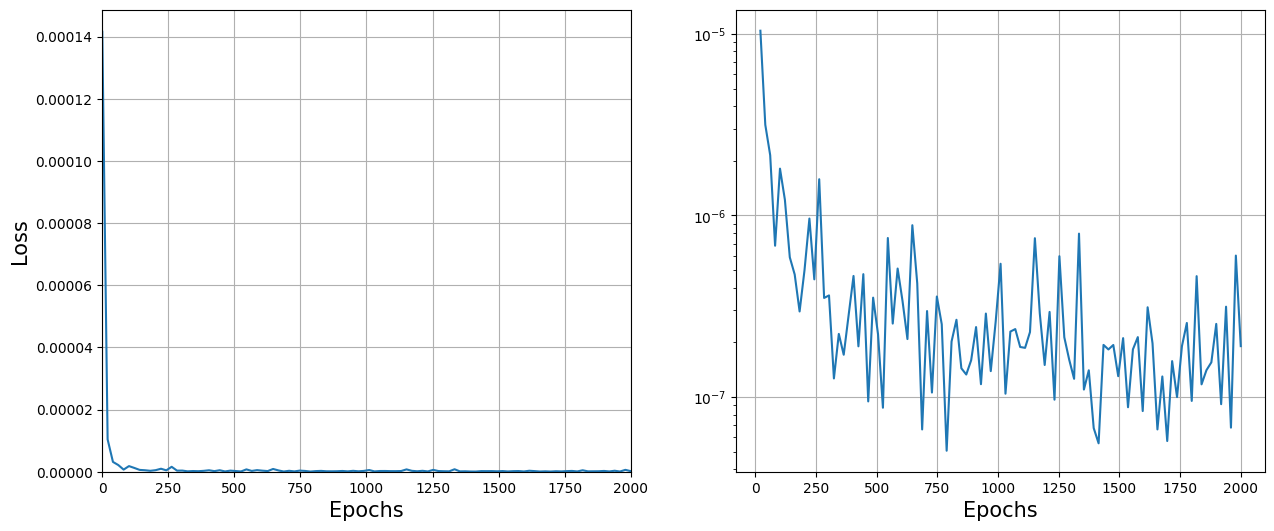

In [30]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs*20, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs*20)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs*20, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [23]:
pred_x.shape

torch.Size([2, 64, 3])

In [31]:
pred_x = odeint(func=model, y0=data_loader.dataset[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
loss = loss_fn(pred_x[-1, :, :, ], data_loader.dataset[:,1,:]) 
loss_list.append(loss.item())
print(f'Final Loss: {loss.item()}')

Final Loss: 9.878669260388051e-08


# Analyzing the trained model

## Data Generation with trained NODE

In [36]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  
c = torch.arange(-1, 8.0, 0.1)

pts = torch.cartesian_prod(a, b, c)  # (num_pts, dim)
pts.shape
t_Start_pred = 0; t_Final_pred = 40; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)

In [37]:
pts.shape

torch.Size([9000, 3])

In [ ]:


node_data = odeint(func=model, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})


node_data = node_data.detach().numpy()
true_data = true_data.detach().numpy()

print(node_data.shape); print(true_data.shape)

## Plotting phase space

In [ ]:
pts

tensor([[-2.0000, -2.0000, -1.0000],
        [-2.0000, -2.0000, -0.9000],
        [-2.0000, -2.0000, -0.8000],
        ...,
        [ 2.0000,  2.0000,  7.7000],
        [ 2.0000,  2.0000,  7.8000],
        [ 2.0000,  2.0000,  7.9000]])

In [ ]:
pts[:, 2] == 2.0

tensor([False, False, False,  ..., False, False, False])

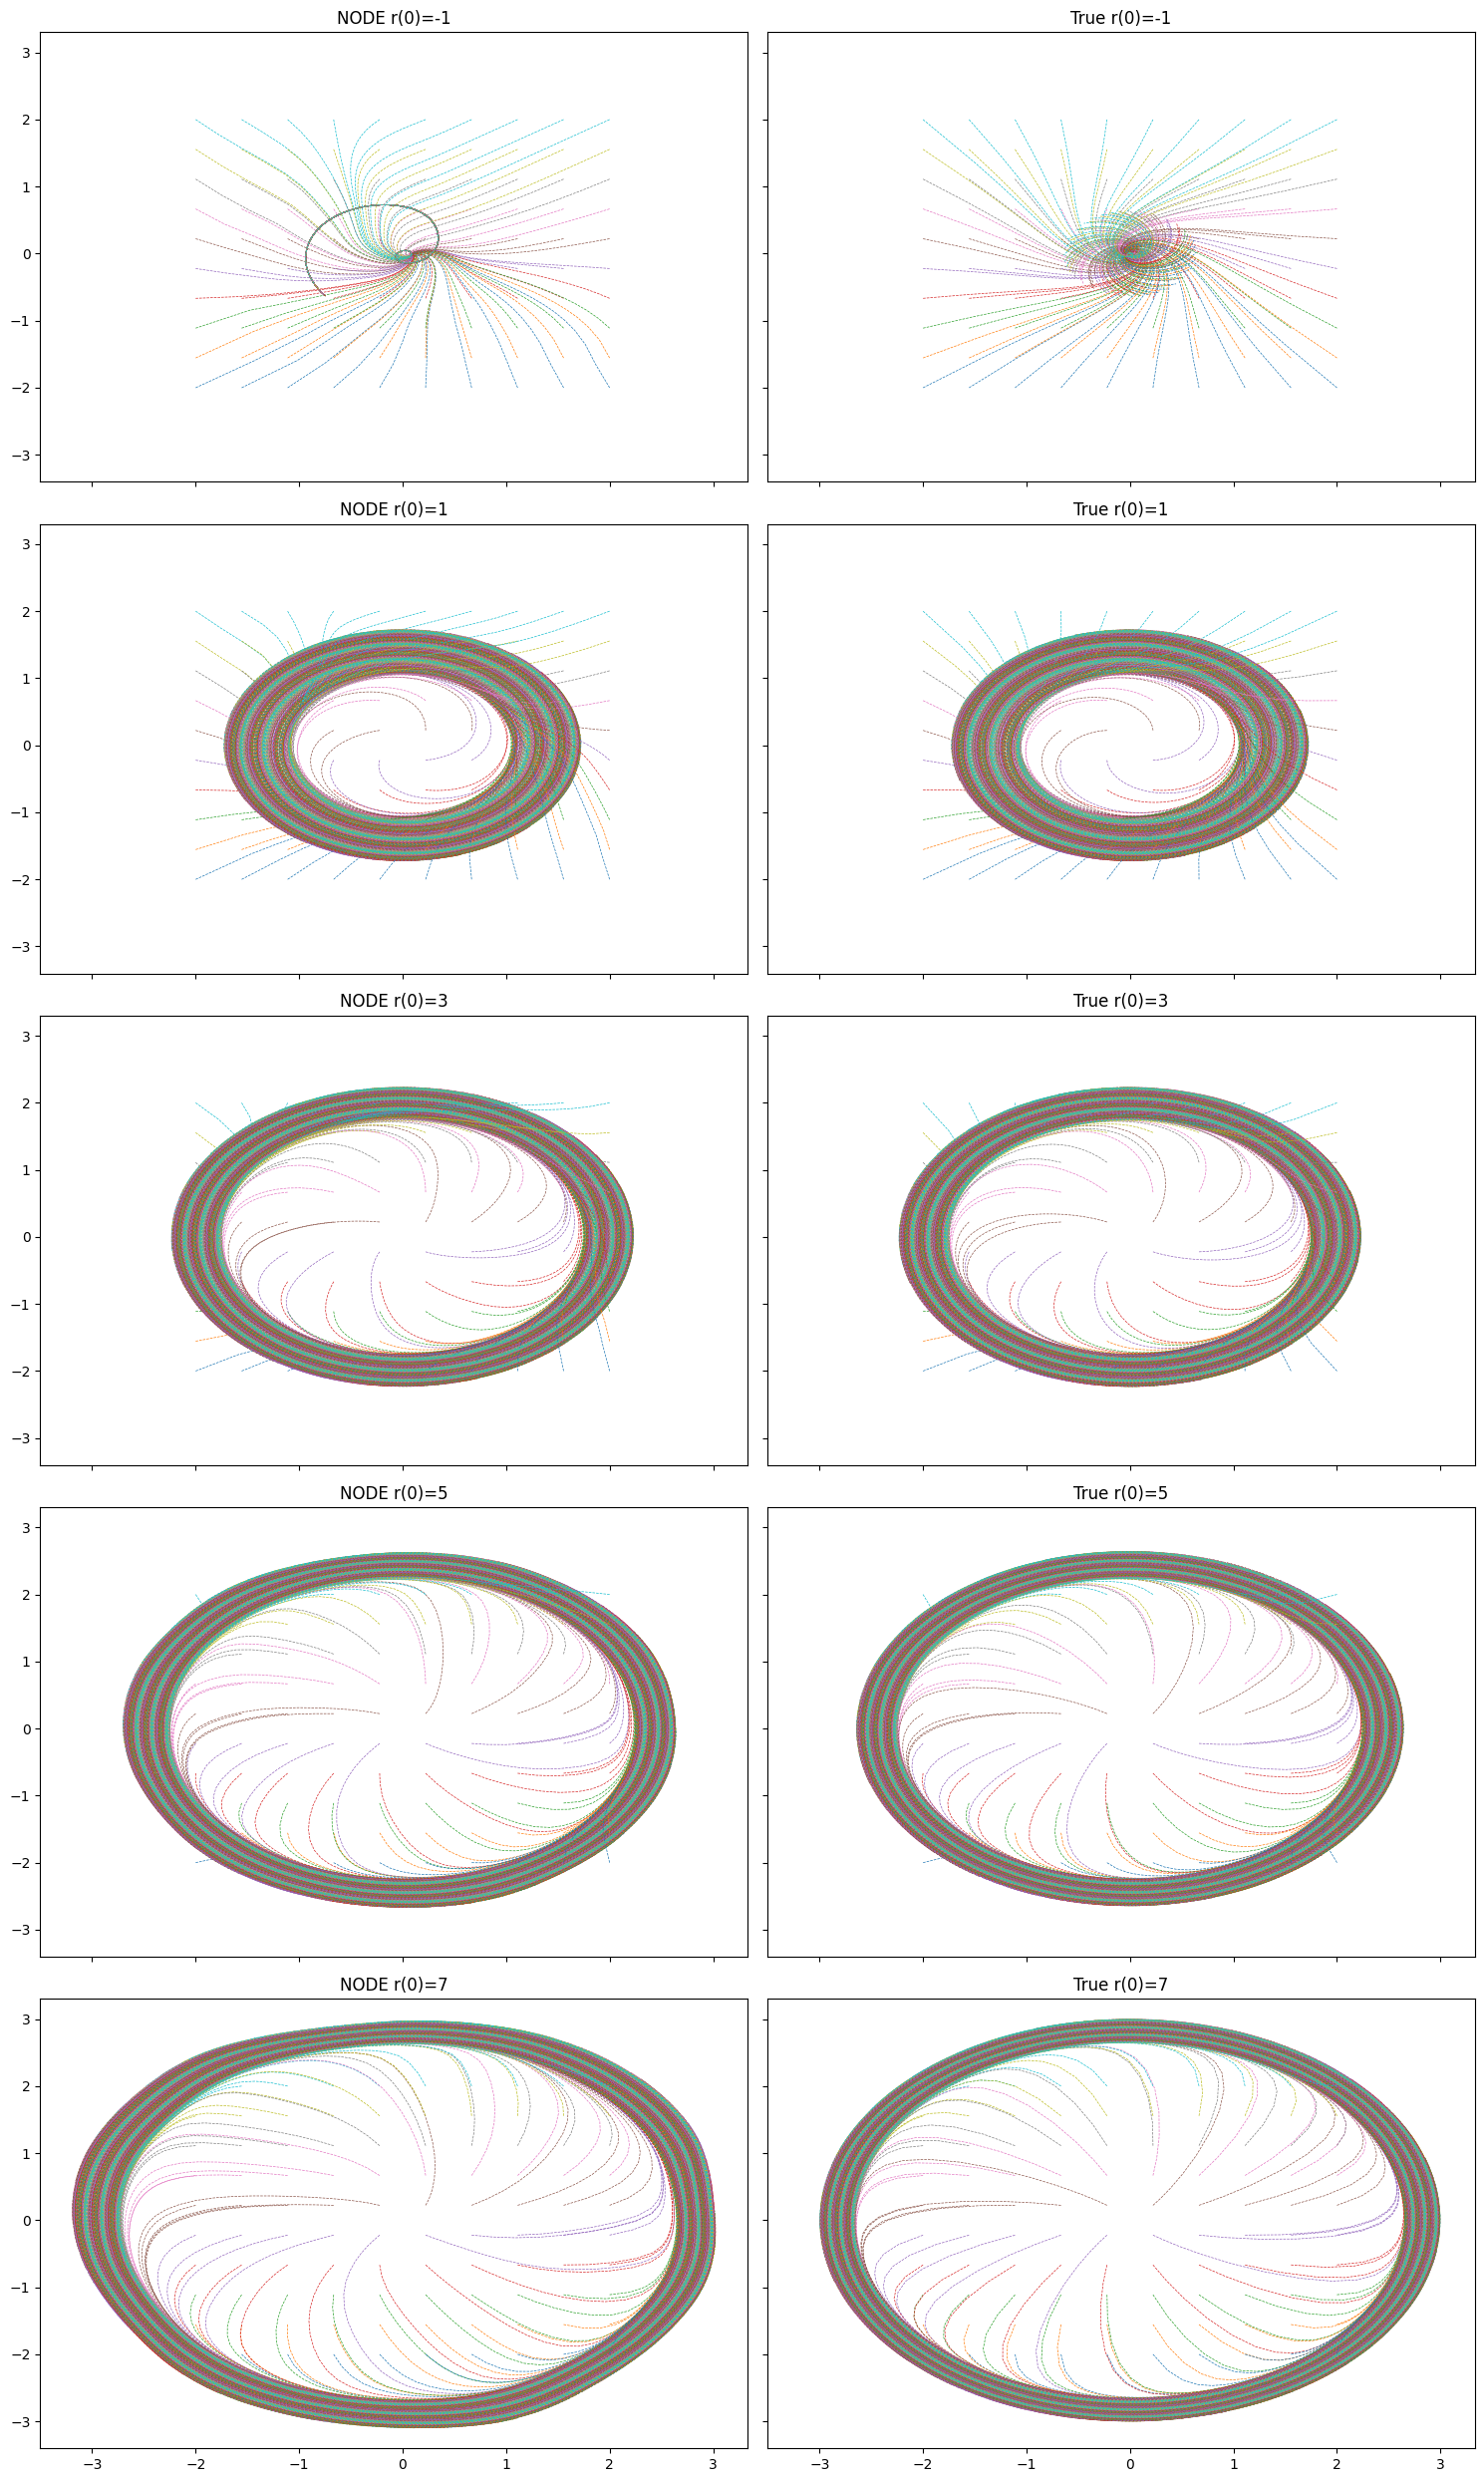

In [ ]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0],
                    node_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0],
                    true_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'X')

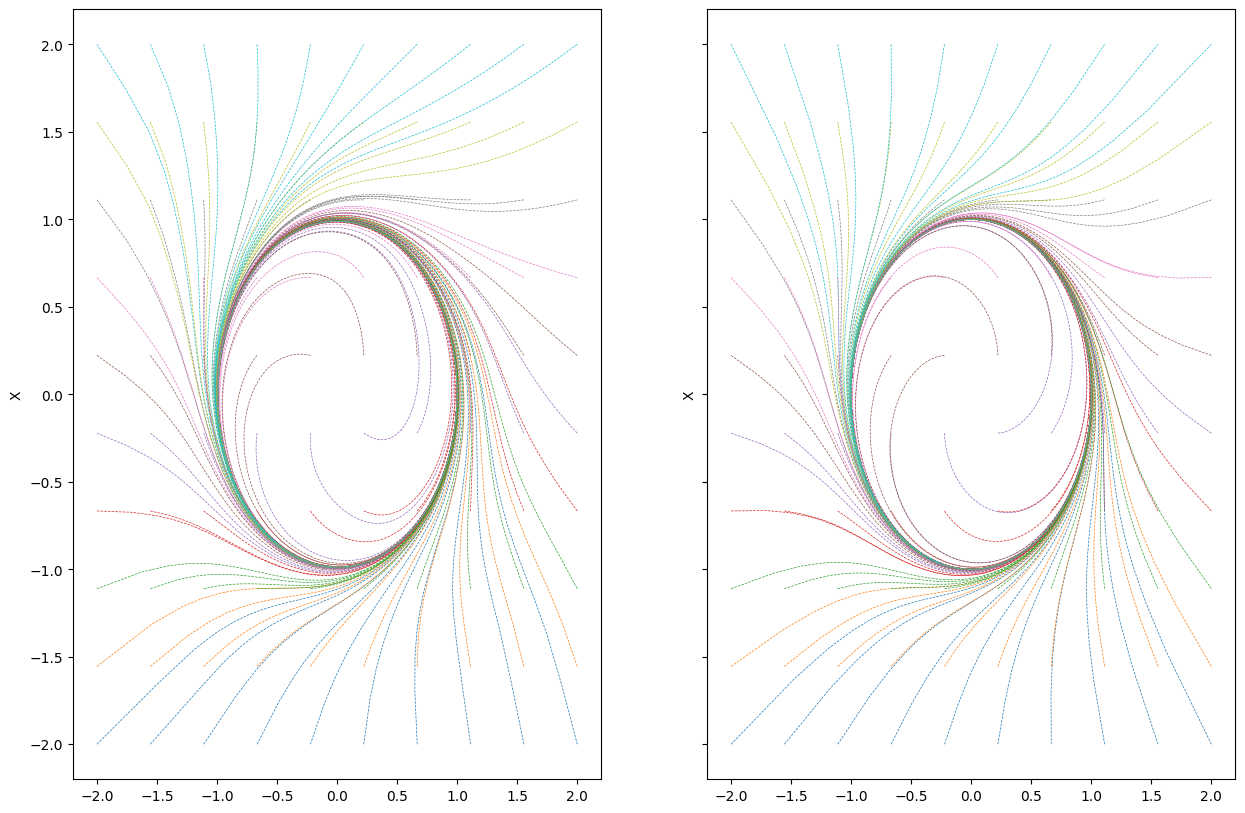

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)

axes[0].plot(node_data[:, :, 0],
                node_data[:, :, 1],
                linewidth=0.5, alpha=1, linestyle='--')
axes[0].set_ylabel('X')


axes[1].plot(true_data[:, :, 0],
                true_data[:, :, 1],
                linewidth=0.5, alpha=1, linestyle='--')
axes[1].set_ylabel('X')

In [ ]:
# Plotting time traces: 

In [36]:
traj = 50
t = t_eval_pred.detach().numpy()
x = node_data[:, traj, :]
x_true = true_data[:, traj, :]



In [37]:
def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates to polar coordinates.
    
    Parameters:
    x, y: float or array-like
        Cartesian coordinates
    
    Returns:
    r: float or array
        Radius (distance from origin)
    theta: float or array
        Angle in radians (from positive x-axis)
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates.
    
    Parameters:
    r: float or array-like
        Radius (distance from origin)
    theta: float or array-like
        Angle in radians (from positive x-axis)
    
    Returns:
    x, y: float or array
        Cartesian coordinates
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [38]:

r, theta = cartesian_to_polar(x[:, 0], x[:, 1])
r_true, theta_true = cartesian_to_polar(x_true[:, 0], x_true[:, 1])

C:\Users\jackr\AppData\Local\Temp\ipykernel_30848\3089097437.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


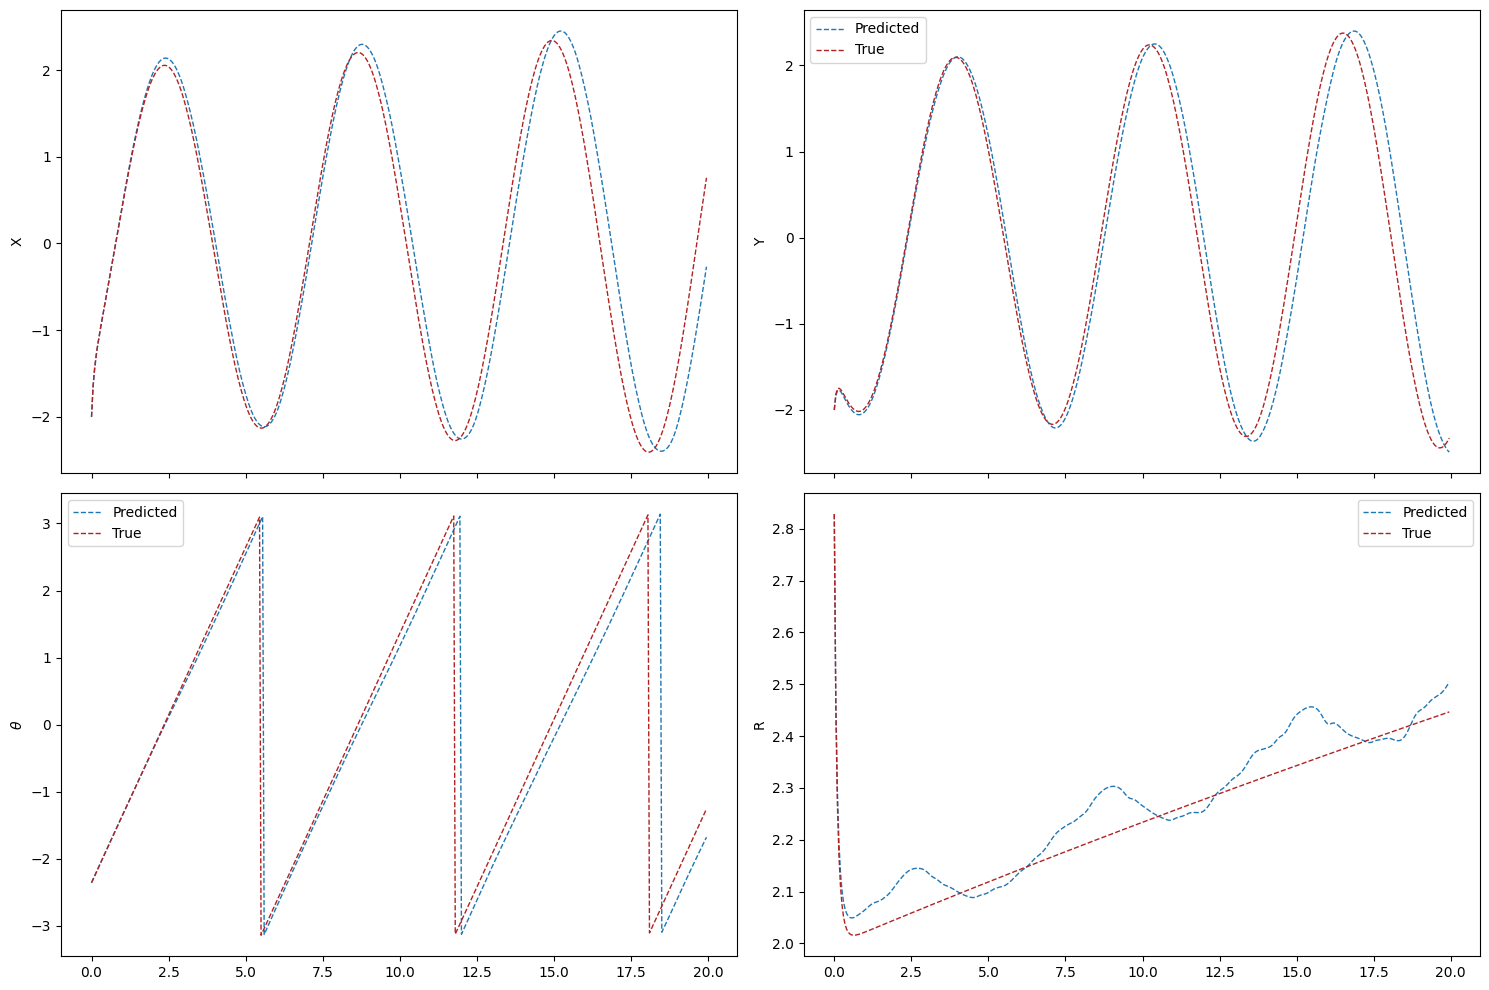

In [39]:


fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)


axes[0, 0].plot(t,
                x[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 0].plot(t, x_true[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 0].set_ylabel('X')

axes[0, 1].legend()


axes[0, 1].plot(t,
                x[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 1].plot(t, x_true[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 1].set_ylabel('Y')
axes[0, 1].legend()

axes[1, 1].plot(t,
                r,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 1].plot(t, r_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 1].set_ylabel('R')
axes[1, 1].legend()


axes[1, 0].plot(t,
                theta,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 0].plot(t, theta_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 0].set_ylabel(r'$\theta$')
axes[1, 0].legend()
plt.tight_layout()
plt.show()